In [1]:
# Initialize Otter
import otter
grader = otter.Notebook("cs109b_hw2.ipynb")

# <img style="float: left; padding-right: 10px; width: 45px" src="https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/iacs.png"> Data Science 2: Advanced Topics in Data Science 

## Homework 2: Bayesian Analysis



**Harvard University**<br/>
**Spring 2023**<br/>
**Instructors**: Mark Glickman & Pavlos Protopapas


<hr style="height:2pt">

In [2]:
# RUN THIS CELL 
import requests
from IPython.core.display import HTML
styles = requests.get(
    "https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/"
    "content/styles/cs109.css"
).text
HTML(styles)

<hr>

#### Instructions
- To submit your assignment follow the instructions given in Canvas.
- Plots should be legible and interpretable without having to refer to the code that generated them, including labels for the $x$- and $y$-axes as well as a descriptive title and/or legend when appropriate.
- When asked to interpret a visualization, do not simply describe it (e.g., "the curve has a steep slope up"), but instead explain what you think the plot *means*.
- Autograding tests are mostly to help you debug. The tests are not exhaustive so passing a test is necessary but not sufficient for full credit. 
- The use of *extremely* inefficient or error-prone code (e.g., copy-pasting nearly identical commands rather than looping) may result in only partial credit.
- We have tried to include all the libraries you may need to do the assignment in the imports cell provided below. Please get course staff approval before importing any additional 3rd party libraries.
- Enable scrolling output on cells with very long output.
- Feel free to add additional code or markdown cells as needed.
- Ensure your code runs top to bottom without error and passes all tests by restarting the kernel and running all cells (note that this can take a few minutes). 
- **You should do a "Restart Kernel and Run All Cells" before submitting to ensure (1) your notebook actually runs and (2) all output is visible**

<hr>

In [3]:
import time
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
from scipy.special import expit

from sklearn.metrics import accuracy_score

In [4]:
# measure notebook runtime
time_start = time.time()

## Notebook Contents
<a id="contents"></a>
- **Dataset Information**
- **Bayesian Logistic Regression with Varying-Intercept Description**
- [**Part 1: Varying-Intercept Model (Simulated Response Variable)**](#part1)
- [**Part 2: Varying-Intercept Model (Real Data)**](#part2)
- [**Part 3: Varying-Coefficients Model**](#part3)
- [**Part 4: Prediction & Model Selection**](#part4)

## Dataset Information

### Contraceptive Usage by Bangladeshi Women

For this assignment, you are provided with datasets `train.csv` and `test.csv` which contain details of contraceptive usage among 1,934 Bangladeshi women.

There are four attributes for each woman along with a response variable, `contraceptive_use`, indicating if she uses contraceptives. The four attributes include:

* `district`: code identifying the district in which the woman lives (60 districts in total)
* `urban`: type of region of residence (binary)
* `living.children`: number of living children
* `age-mean`: age of the woman (in years, centered around mean)

The task is to build a classification model that can predict if a given woman uses contraceptives.

The following cell will load and inspect the train and test datasets.

TRAINING DATA INFO:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 967 entries, 0 to 966
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   district           967 non-null    int64  
 1   urban              967 non-null    int64  
 2   living.children    967 non-null    int64  
 3   age_mean           967 non-null    float64
 4   contraceptive_use  967 non-null    int64  
dtypes: float64(1), int64(4)
memory usage: 37.9 KB

TEST DATA INFO:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 967 entries, 0 to 966
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   district           967 non-null    int64  
 1   urban              967 non-null    int64  
 2   living.children    967 non-null    int64  
 3   age_mean           967 non-null    float64
 4   contraceptive_use  967 non-null    int64  
dtypes: float64(1), int64(4)
m

,district,urban,living.children,age_mean,contraceptive_use
0,35,0,4,2.4400,0
1,22,0,2,-1.5599,1
2,29,0,2,-8.5599,1


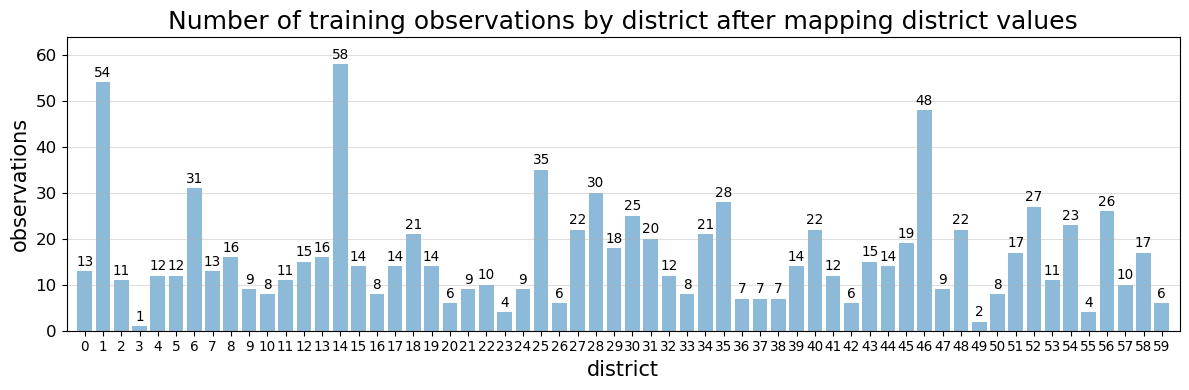

In [5]:
# loading and inspecting the data
df_train = pd.read_csv("data/train.csv")
df_test = pd.read_csv("data/test.csv")

# print dataset summary info for ease of reference
print("TRAINING DATA INFO:\n")
df_train.info()
print("\nTEST DATA INFO:\n")
df_test.info()
print("\nTRAINING DATA SUMMARY STATS:\n")
print(df_train.describe())
print("\nTRAINING DATA FIRST ROWS OF DATA:")
display(df_train.head(3))
print()

# And plot observation counts by district also just for reference
def plot_value_counts(value_counts, var_name, font_perc):
    """Generates barplot from pandas value_counts series"""
    fig, ax = plt.subplots(figsize=(12, 4))

    max_y = max(value_counts.values)
    n_cats = len(value_counts)

    ax.bar(range(n_cats), value_counts.values, alpha=0.5)

    for x, y in enumerate(value_counts):
        ax.text(
            x, y+max_y*.02,
            "{:,}".format(y),
            color="k",
            fontsize=14*font_perc,
            horizontalalignment="center"
        ) 

    ax.set_title(
        "Number of training observations by {} after mapping district values".format(
            var_name
        ),
        fontsize=18
    )
    ax.set_xlabel("{}".format(var_name), fontsize=15)
    ax.set_ylabel("observations", fontsize=15)
    ax.set_xticks(range(n_cats))
    ax.set_xticklabels(value_counts.index)
    ax.tick_params("x", labelsize=14*font_perc)
    ax.tick_params("y", labelsize=12)
    ax.set_ylim(top=max_y+(max_y*.1))

    ax.grid(":", axis="y", alpha=0.4)
    ax.margins(x=.01)
    plt.tight_layout()
    plt.show();

# plot and print summary of resulting district values
dist_counts = df_train["district"].value_counts().sort_index()

plot_value_counts(dist_counts, "district", .7)



## Bayesian Logistic Regression with Varying-Intercept Description


The first model we'd like to fit to the contraceptives data will be a **varying-intercept logistic regression** model, where the model's intercept varies by district.

Prior distributions:

$$
\begin{split}
\beta_{0j} &\sim N(\mu_0,\sigma_0^2)\; \text{, with} \;\; \mu_0 \sim N(0,10000)\; \text{and} \; \; \frac{1}{\sigma^2_0} \sim \text{Gamma}(0.1,0.1)
\\
\beta_1 &\sim N(0,10000) 
\\ \\ 
\beta_2 &\sim N(0,10000)
\\ \\ 
\beta_3 &\sim N(0,10000)
\\ \\
\end{split}
$$

Model for data:

$$
\begin{split}
Y_{ij} & \sim \text{Bernoulli}(p_{ij})
\\ \\
\text{logit}\:p_{ij} &= \beta_{0j} + \beta_1 \times \text{urban} + \beta_2 \times \text{living.children} + \beta_3 \times \text{age-mean}
\\ \\
\end{split}
$$

Where $Y_{ij}$ is 1 if woman $i$ in district $j$ uses contraceptives, and 0 otherwise, and where $i \in \{1,...,N\}$ and $j \in \{1,...,J\}$. $N$ is the number of observations in the data, and $J$ is the number of districts. The above notation assumes $N(\mu, \sigma^2)$ is a Normal distribution with mean $\mu$ and variance $\sigma^2$.

**PLEASE NOTE:** The $\text{Gamma}$ distribution cited above, uses the $\text{Gamma}(\alpha, \beta)$ parametrization, where $\alpha$ is the shape and $\beta$ is the rate.  

<a id="part1"></a>

### <div class='exercise'>Part 1: Varying-Intercept Model (Simulated Response Variable)</div> 

[Return to contents](#contents)

<!-- BEGIN QUESTION -->

<div class='exercise'><b>Q1.1 - Simulate Response</b></div>

To verify that PyMC can indeed recover the hidden parameter values, we'll simulate values of the response variable, `contraceptive_use`, for observations in the training set using the 4 predictors and *hard-coded model parameters of our choosing*. Then, using this simulated data, we'll check if PyMC can get back the parameter values that we hard-coded. If it does, we'll have some reason to believe that it can recover the hidden parameter values that generated the *real* data.

**Note: Synthetic response values generated using the parameters below will only be used in question 1.1 - 1.4**.

Generate $Y$ using the training data and the following hard-coded values:

$$
\begin{split}
\mu_0 &= 2
\\ \\
\sigma^2_0 &= 1
\\ \\
\beta_{0j} &\sim N(\mu_0,\sigma_0^2) \; \text{for all sixty districts}
\\ \\
\beta_1 &= 4
\\ \\ 
\beta_2 &= -3
\\ \\
\beta_3 &= -2
\\ \\
\end{split}
$$

Save your simulated values in a numpy array called `simulated_Y`.

**Verify that these parameters generate data in which an average of 46% to 49% of subjects use contraceptives.**

In [6]:
# set seed for consistency across runs
np.random.seed(109)
# your code here

# Define prior mean for Beta_0
m_0 = 2
# Define prior standard deviation for Beta_0
sigma_0 = 1

# Create an empty list to store the simulated Beta_0 values
Beta_0s = []

# Iterate over all 60 districts
for i in range(60):
    
    # Simulate Beta_0 from the prior distribution
    Beta_0s.append(np.random.normal(m_0, sigma_0))

# Define the values for the three regression coefficients
B1 = 4
B2 = -3
B3 = -2

# Create an empty list to store the simulated response variables
simulated_Y = []

# Iterate over each observation in the training data
for i, observation in df_train.iterrows():
    # Calculate the linear predictor using the simulated Beta_0 value for the appropriate district
    linear_predictor = Beta_0s[int(observation.district-1)] + B1*observation.urban + B2*observation['living.children'] + B3*observation.age_mean
    
    # Transform the linear predictor into a probability using the logistic function
    prob = np.exp(linear_predictor) / (1 + np.exp(linear_predictor))
    
    # Simulate a response variable (0 or 1) using a Bernoulli distribution with the calculated probability
    y = np.random.choice([1,0], p=[prob,1-prob])
    
    # Add the simulated response variable to the list
    simulated_Y.append(y)

In [7]:
# Verify that these parameters generate data in which an average of 46% to 49% of 
# subjects use contraceptives.

print("These parameters generate data with an average of {}".format(np.mean(simulated_Y)))

These parameters generate data with an average of 0.48190279214064113


In [8]:
grader.check("q#1.1")

q#1.1 results: All test cases passed!

<!-- BEGIN QUESTION -->

<div class='exercise'><b>Q1.2 - Fit Varying-Intercept Model (Simulated Data)</b></div>

Create and fit the varying-intercept model specified above to your simulated data. Reasonably good convergence may require adjustments to the number of tuning samples and the target acceptance rate as suggested by any warnings from PyMC.

In [9]:
%%time

# your code here

# create a new PyMC3 model
with pm.Model() as model:
    
    # prior distribution for the intercept term
    mu_0 = pm.Normal("mu_0", mu=0, sigma=100)
    
    # prior distribution for the precision parameter of the intercept term
    tau_0 = pm.Gamma("tau_0", alpha=0.1, beta=0.1)
    
    # prior distribution for the intercept term for each district
    # the distribution is centered at mu_0 and has precision tau_0
    B0s = pm.Normal("B0s", mu=mu_0, tau=tau_0, shape=60)
    
    # prior distribution for the coefficient of urban
    Beta_1 = pm.Normal("Beta_1", mu=0, sigma=100)
    
    # prior distribution for the coefficient of living.children
    Beta_2 = pm.Normal("Beta_2", mu=0, sigma=100)
    
    # prior distribution for the coefficient of age_mean
    Beta_3 = pm.Normal("Beta_3", mu=0, sigma=100)
    
    # linear predictor
    # the intercept term for each observation is determined by the district it belongs to
    # the remaining terms are the coefficients of the corresponding predictors
    p_logit = B0s[df_train.district-1] + Beta_1*df_train.urban + Beta_2*df_train['living.children'] + Beta_3*df_train.age_mean
    
    # likelihood of the observed data
    # we assume that the response variable is Bernoulli distributed with the given linear predictor
    our_likelihood = pm.Bernoulli('our_likelihood', logit_p=p_logit, observed=simulated_Y)



CPU times: user 135 ms, sys: 18.2 ms, total: 153 ms
Wall time: 222 ms


<!-- BEGIN QUESTION -->

<div class='exercise'><b>Q1.3 - Convergence Diagnostics</b></div>

Plot the trace plots of the MCMC sampler for the parameters $\mu_0, \frac{1}{\sigma^2_0}\text{ (a.k.a., }\tau_0\text{)}, \beta_1, \beta_2, \beta_3$. Based on these and the R-hat values, does it look like the samplers converged? Explain your reasoning.


**Hint:** Use the Arviz `plot_trace()` function

The Gelman-Rubin statistic (or $\hat{R}$ in this case) compares the within-chain variance to the between-chain variance, and if it is close to 1, that's a good indication that the chains have converged. If the statistic is greater than 1.1, it suggests that the chains may not have fully converged yet. It is computed as follows:

$$\hat{R} = \frac{\frac{n-1}{n}W + \frac{1}{n}B}{W}$$

where $n$ is the number of MCMC chains, $W$ is the within-chain variance, and $B$ is the between-chain variance. The within-chain variance is estimated as the average variance of each MCMC chain, while the between-chain variance is estimated as the variance of the means of all chains.

To understand why the Gelman-Rubin statistic can tell us if the samplers have converged, consider the following argument. Suppose we have $m$ MCMC chains, each with $n$ samples, and let $\theta_{i,j}$ denote the $j$th sample from the $i$th chain. We can estimate the posterior mean of the parameter of interest as:

$$\hat{\mu} = \frac{1}{mn}\sum_{i=1}^m\sum_{j=1}^n\theta_{i,j}$$

The within-chain variance can be estimated as:

$$W = \frac{1}{m}\sum_{i=1}^m s_i^2$$

where $s_i^2$ is the sample variance of the $i$th chain. The between-chain variance can be estimated as:

$$B = \frac{n}{m-1}\sum_{i=1}^m(\bar{\theta}_i-\bar{\theta})^2$$

where $\bar{\theta}i$ is the sample mean of the $i$th chain, $\bar{\theta}=\frac{1}{m}\sum{i=1}^m\bar{\theta}_i$ is the overall mean, and $n/(m-1)$ is a correction factor to account for the fact that the sample means are not independent.

The Gelman-Rubin statistic compares the ratio of the within-chain variance to the between-chain variance. If the chains have converged to the same stationary distribution, then the within-chain variance should be similar across all chains, and the between-chain variance should be small compared to the within-chain variance. In this case, the Gelman-Rubin statistic will be close to 1.

On the other hand, if the chains have not converged, then the within-chain variance may differ across chains, and the between-chain variance may be large compared to the within-chain variance. In this case, the Gelman-Rubin statistic will be greater than 1, indicating that the chains have not fully converged yet.

In this plots, our $\hat{R}$'s seem to be close to 1. This can be confirmed by printing out a value-counts, that shows that most $\hat{R}$'s are exactly 1 (with the last one being 1.01). This suggests that our chains have likely converged. 

In [10]:
%%time 
# your code here

# We use the sample function to draw samples from the posterior distribution 
# Number of samples to draw: 2000
# `tune=2000`: number of tuning samples to discard at the beginning of the sampling process
# `target_accept=.98` for the target acceptance rate of the 
#  Metropolis-Hastings algorithm used for sampling
with model:
    
    # The trace variable will contain the samples drawn from the posterior distribution
    trace = pm.sample(draws=2000, chains=4, tune=2000, target_accept=.98)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_0, tau_0, B0s, Beta_1, Beta_2, Beta_3]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 81 seconds.


CPU times: user 15.8 s, sys: 737 ms, total: 16.5 s
Wall time: 1min 32s


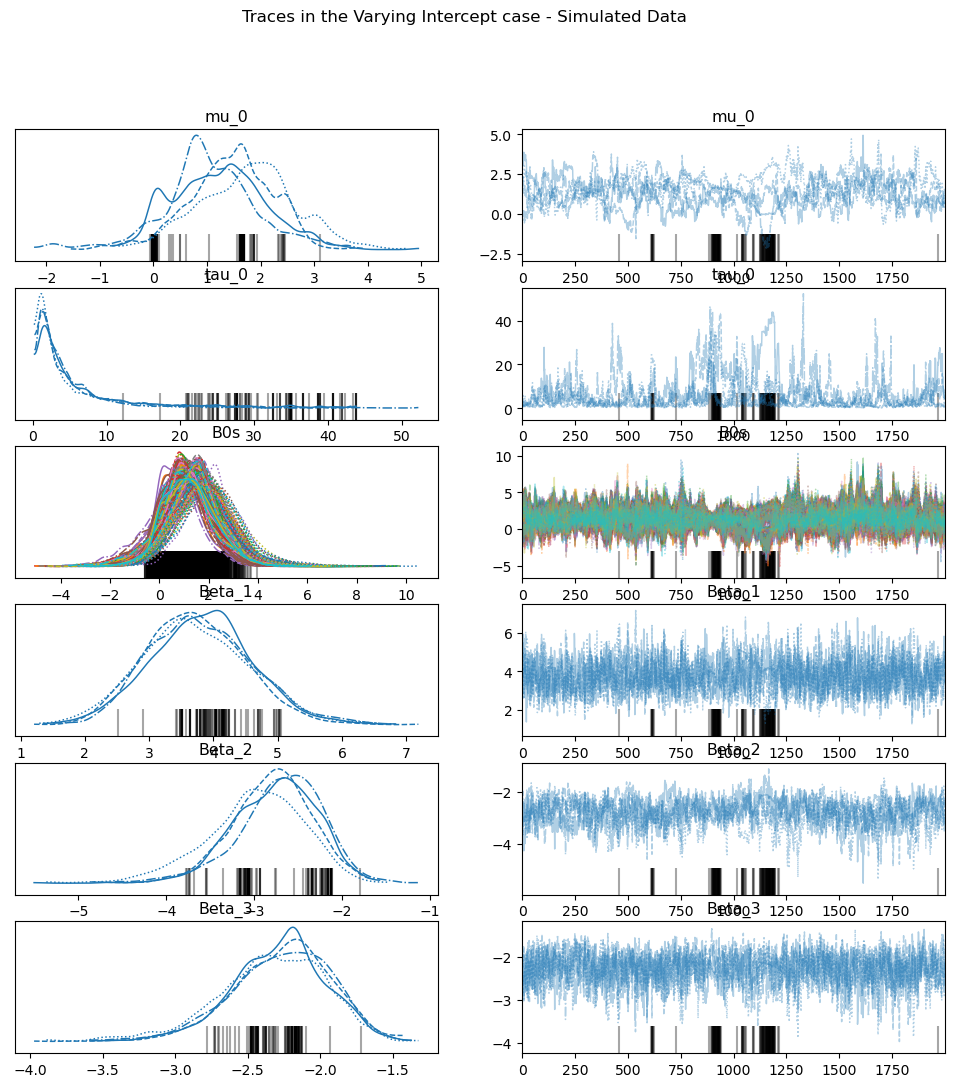

In [11]:
# plot the trace plot of the mu0 parameter using Arviz
az.plot_trace(trace, var_names = ["mu_0", "tau_0", "B0s", "Beta_1", "Beta_2", "Beta_3"]);
plt.suptitle('Traces in the Varying Intercept case - Simulated Data');

In [12]:
summary = az.summary(trace)

# extract the Gelman-Rubin statistic for each parameter
gelman_rubin = summary['r_hat']

# print the value counts for the Gelman-Rubin statistic
gelman_rubin.value_counts()

1.05    37
1.06    10
1.04    10
1.07     3
1.03     2
1.08     1
1.00     1
1.01     1
Name: r_hat, dtype: int64

<!-- BEGIN QUESTION -->

<div class='exercise'><b>Q1.4 - Inspecting Posteriors</b></div>

Plot histograms of the posterior distributions for the parameters $\beta_{0,9}$, $\beta_{0,19}$, $\beta_{0,29}$, ..., $\beta_{0,59}$. Are the actual parameters that you generated contained within these posterior distributions?

**Hint: The `az.plot_posterior()` function might be helpful here.**

We can clearly see that the actual parameters that we generated are contained within the posterior distributions. 

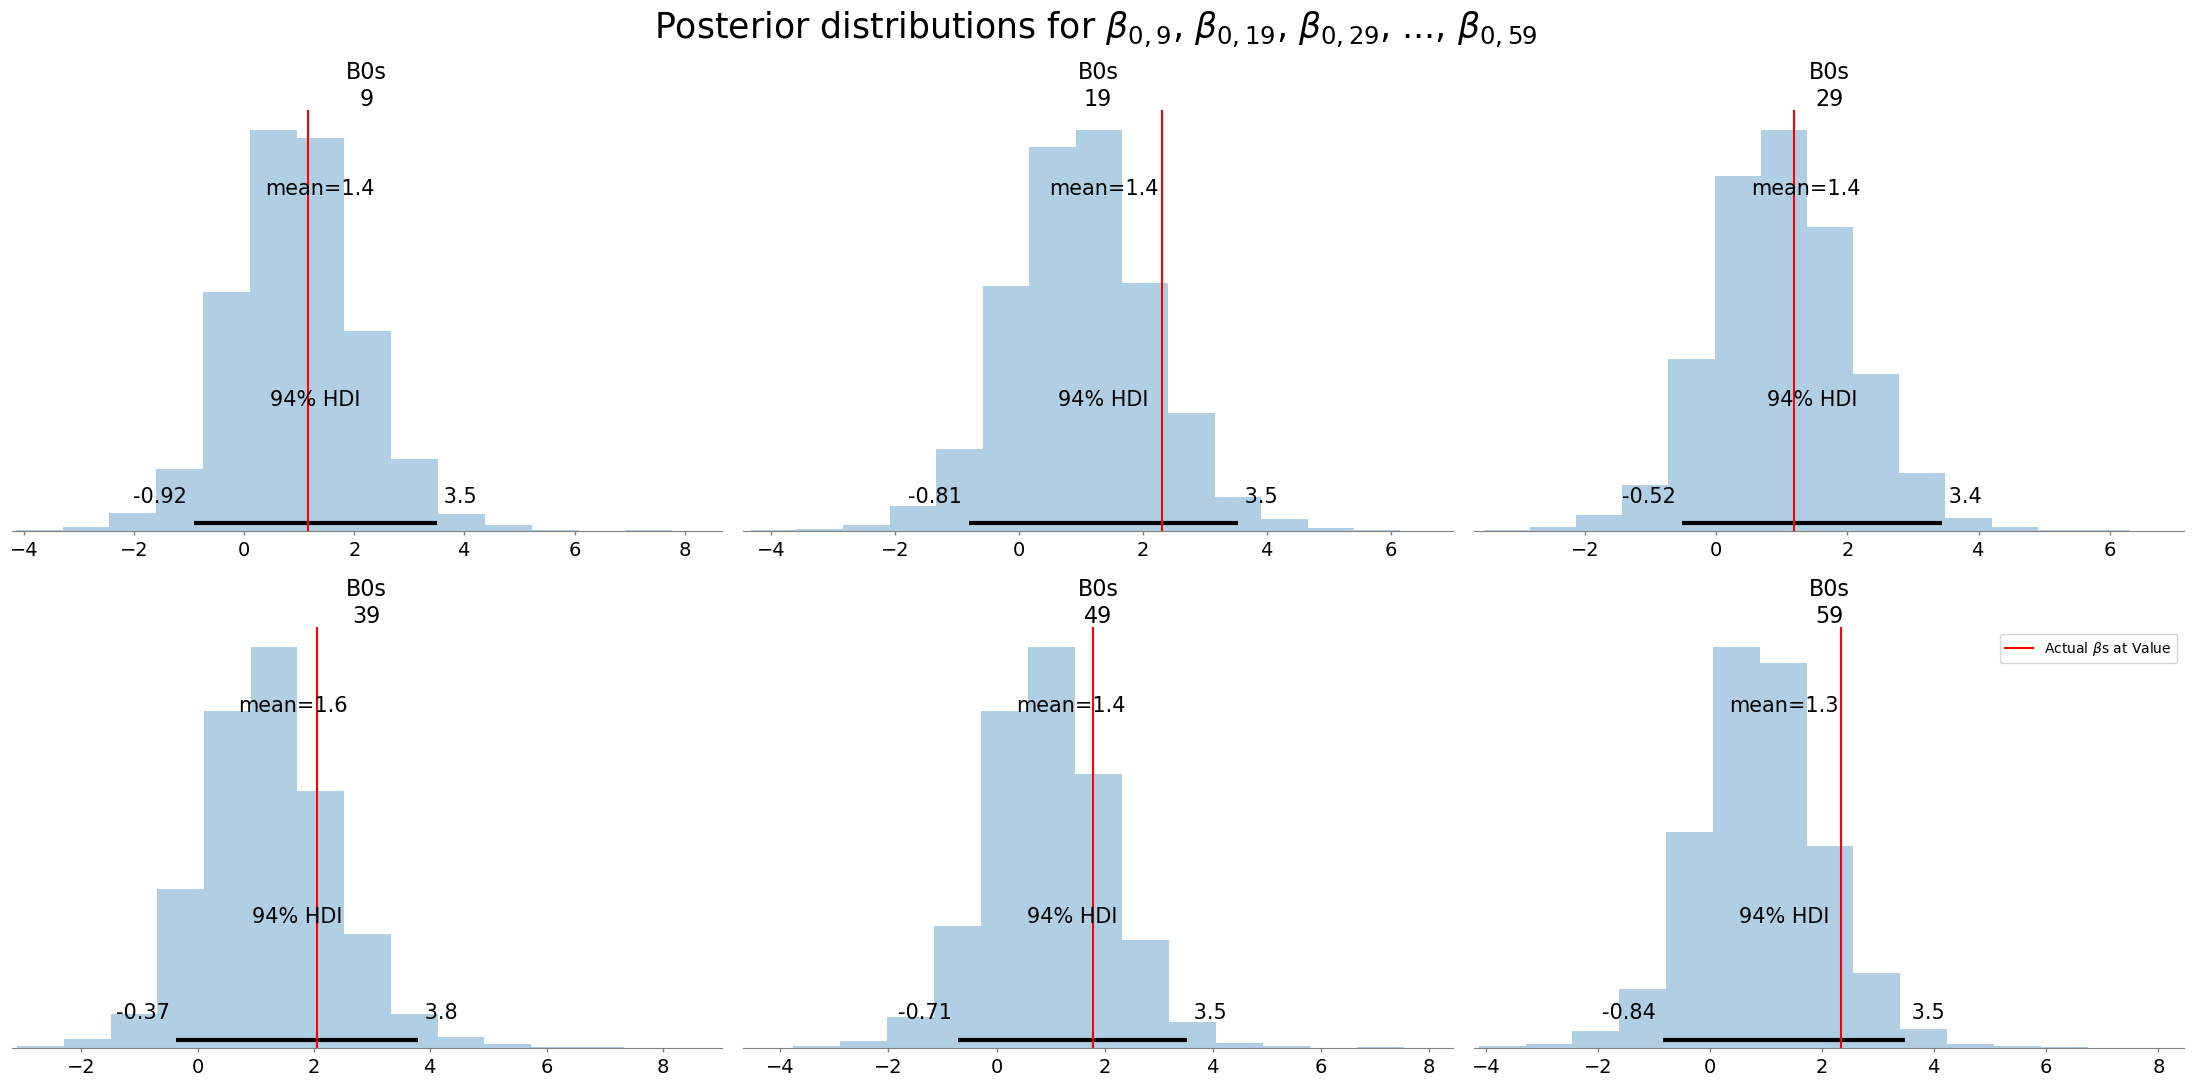

In [13]:
# your code here


# Select a subset of the posterior samples for parameter `B0s`. 
# It extracts every 10th sample starting from the 9th sample and up to the 60th.
beta0_samples = trace.posterior['B0s'][:, :, 9:60:10]

# Creates a new array that contains the same values as `beta0_samples`. 
# It selects the same indices as in `beta0_samples` but directly from the original `Beta_0s` array.
relevant_betas = Beta_0s[9:60:10]

# This line generates a histogram of the posterior samples for `beta0_samples` using the `plot_posterior` function from `arviz` package.
az.plot_posterior(beta0_samples, kind='hist')


fig = plt.gcf()

for i, plot in enumerate(fig.get_axes()):
    plot.axvline(relevant_betas[i], label=r'Actual $\beta$s at Value', color='red')
    
plt.suptitle(r"Posterior distributions for $\beta_{0,9}$, $\beta_{0,19}$, $\beta_{0,29}$, ..., $\beta_{0,59}$", 
             fontsize=25)
plt.tight_layout()
plt.legend()
plt.show()


<a id="part2"></a>
    
<!-- <div class="alert alert-block alert-danger" style="color:black;background-color:#E7F4FA"> -->

### <div class='exercise'>Part 2: Varying-Intercept Model (Real Data)</div> 

[Return to contents](#contents)


<!-- BEGIN QUESTION -->

<div class='exercise'><b>Q2.1 - Fit Varying-Intercept Model (Real Data)</b></div>

Now we'll fit our model to the *actual* data. Construct and fit the varying-intercept model to the real training data.

In [14]:
# your code here

# Storing the real dependent variable
real_train_Y = df_train['contraceptive_use']

with pm.Model() as model:
    
    # Prior distribution for the model
    mu_0 = pm.Normal("mu_0", mu=0, sigma=100) # N(0, 100^2)
    tau_0 = pm.Gamma("tau_0", alpha=0.1, beta=0.1) # Gamma(0.1, 0.1)
    sigma_0 = pm.Deterministic("sigma_0", pm.math.sqrt(1/tau_0)) # using fact that 1/sigma^2_0 ~ Gamma(0.1, 0.1)

    
    # Varying intercepts for 60 districts
    B0s = pm.Normal("Beta_0", mu=mu_0, tau=tau_0, shape=60)
    
    # Fixed effects
    Beta_1 = pm.Normal("Beta_1", mu=0, sigma=100)
    Beta_2 = pm.Normal("Beta_2", mu=0, sigma=100)
    Beta_3 = pm.Normal("Beta_3", mu=0, sigma=100)
    
    # Creating logit probability using linear equation with varying intercepts
    p_logit = B0s[df_train.district-1] + Beta_1*df_train.urban + Beta_2*df_train['living.children'] + Beta_3*df_train.age_mean
    
    # Likelihood of the data, assuming Bernoulli distribution
    our_likelihood = pm.Bernoulli('our_likelihood', 
                                  logit_p=p_logit, 
                                  
                                  # Making sure to replace observed data with real data
                                  observed=real_train_Y)


<!-- BEGIN QUESTION -->

<div class='exercise'><b>Q2.2 - Convergence Diagnostics</b></div>

Check the convergence by examining the trace plots and R-hats, as you did with the simulated data. What do you observe?

As with the simulated data, one may say for similar reasons with high confidence that the chains have converged.  

In [15]:
# your code here

# We use the sample function to draw samples from the posterior distribution 
# Number of samples to draw: 2000
# `tune=2000`: number of tuning samples to discard at the beginning of the sampling process
# `target_accept=.98` for the target acceptance rate of the 
#  Metropolis-Hastings algorithm used for sampling
with model:
    
    # The trace variable will contain the samples drawn from the posterior distribution
    trace = pm.sample(draws=2000, chains=4, tune=2000, target_accept=.98)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_0, tau_0, Beta_0, Beta_1, Beta_2, Beta_3]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 62 seconds.


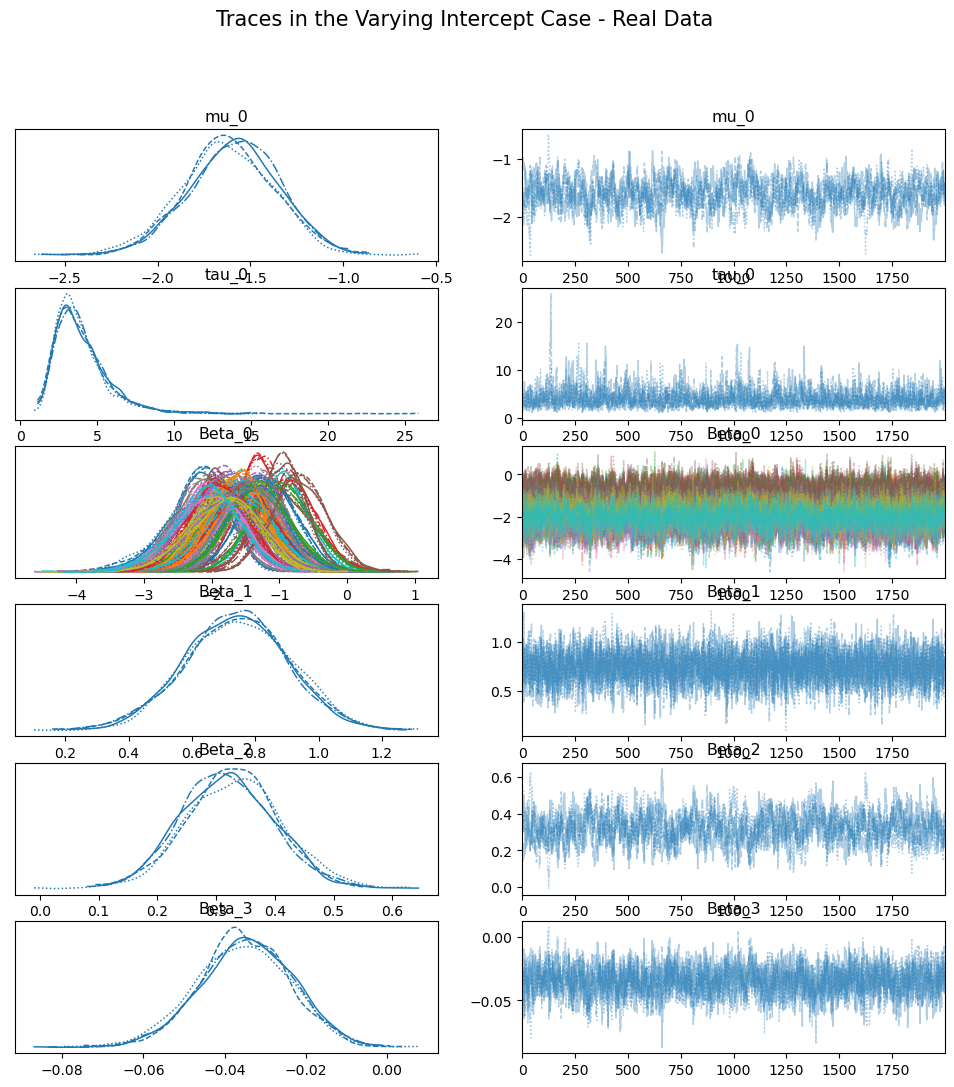

In [16]:
# plot the trace plot of the mu0 parameter using our plotting function
az.plot_trace(trace, ["mu_0", "tau_0", "Beta_0", "Beta_1", "Beta_2", "Beta_3"]);
plt.suptitle('Traces in the Varying Intercept Case - Real Data', fontsize=15);

In [17]:
summary = az.summary(trace)

# extract the Gelman-Rubin statistic for each parameter
gelman_rubin = summary['r_hat']

# print the value counts for the Gelman-Rubin statistic
gelman_rubin.value_counts()

1.00    64
1.01     2
Name: r_hat, dtype: int64

<!-- BEGIN QUESTION -->

<div class='exercise'><b>Q2.3 - Districts with Highest & Lowest Rates of Contraceptive Usage</b></div>

Based on the posterior means, which district has the highest base rate of contraceptive usage (independent of other factors like urban population)? Which district has the lowest? Explain how you arrived at these conclusions, interpreting any numerical values that played a role in your reasoning.

District with highest base rate of contraceptive usage: 56; 
District with lowest base rate of contraceptive usage: 11

In [18]:
# your code here

summary_df = pd.DataFrame(az.summary(trace, var_names=['Beta_0']))

# Extract the posterior means for the base rate parameters
beta0_means = summary_df['mean']

# Identify the district with the highest and lowest base rate of contraceptive usage
max_index = np.argmax(beta0_means)
min_index = np.argmin(beta0_means)

print(f"The district with the highest base rate of contraceptive usage is district {max_index+1}.")
print(f"The district with the lowest base rate of contraceptive usage is district {min_index+1}.")

The district with the highest base rate of contraceptive usage is district 56.
The district with the lowest base rate of contraceptive usage is district 11.


<!-- BEGIN QUESTION -->

<div class='exercise'><b>Q2.4 - Varying Intercept? Conclusions from Posterior Samples</b></div>

What are the posterior means of $\mu_0$ and $\sigma_0$? Do these values offer any evidence in support of or against the varying-intercept model, compared to a model with a single intercept value for all districts? Explain why or why not.


**Hint:** Both ArviZ's `plot_posterior` and [`plot_forest()`](https://arviz-devs.github.io/arviz/api/generated/arviz.plot_forest.html) functions will prove useful here.

The posterior distribution of $\mu_0$ tells us about the average response of the districts in the sample. If the mean of this distribution is significantly different from 0, it suggests that there is systematic variation in the intercepts across districts that cannot be explained by the fixed effects alone. Similarly, the posterior distribution of $\sigma_0$ tells us about the variability in the intercepts across districts. If the mean of this distribution is significantly different from 1, it suggests that the variability in the intercepts is not consistent with what would be expected under a model with a single intercept value for all districts.

Considering that posterior means of $\mu_0$ and $\sigma_0$ are $\approx -1.6$ and $\approx 0.5$ respectively and looking at the the posterior plot, we see that the mean of the distribution is significantly different from 0 for $\mu_0$ and significantly different from 1 for $\sigma_0$. This is evidence for a varying intercept model. 

The forest plot shows the posterior distributions of the intercepts for each district. If the credible intervals for most of the districts do not overlap with 0, it suggests that the intercepts are systematically different across districts, even after accounting for the fixed effects. 

Looking at the forest plot for $\mu_0$, we see that the credible intervals for each district do not overlap with 0. This is once again evidence in favour of a varying-intercept model. 

Finally, looking at the forest plot for $\sigma_0$ shows the variability in the intercepts across districts. The credible intervals for most of the districts do not overlap with 1, hence suggesting that the variability in the intercepts is not consistent with what would be expected under a model with a single intercept value for all districts. This further supports the conclusion that a varying intercept model is appropriate.

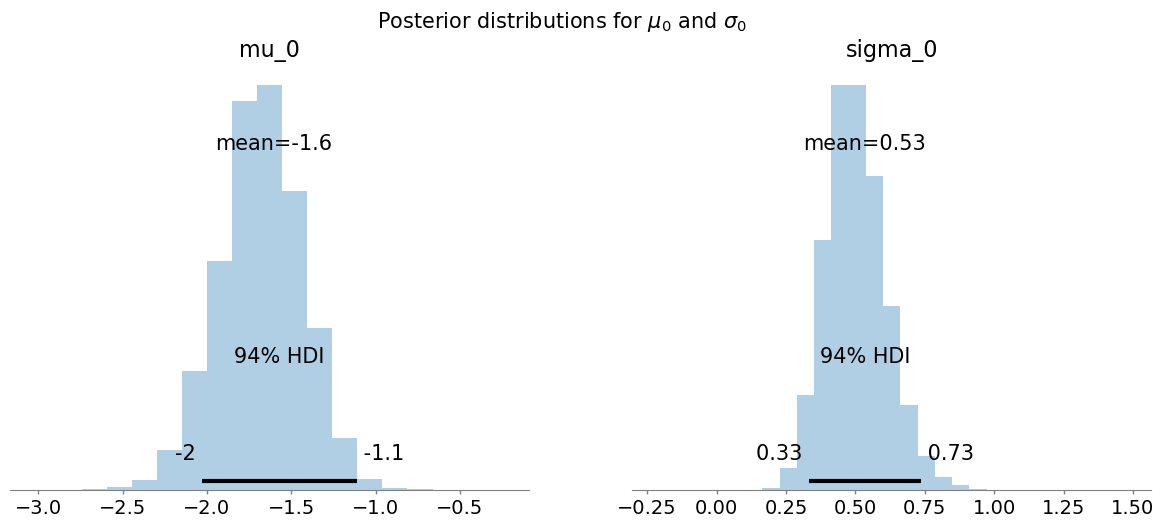

In [19]:
# your code here

az.plot_posterior(trace, ['mu_0', 'sigma_0'], kind='hist');
plt.suptitle(r'Posterior distributions for $\mu_0$ and $\sigma_0$', fontsize=15);

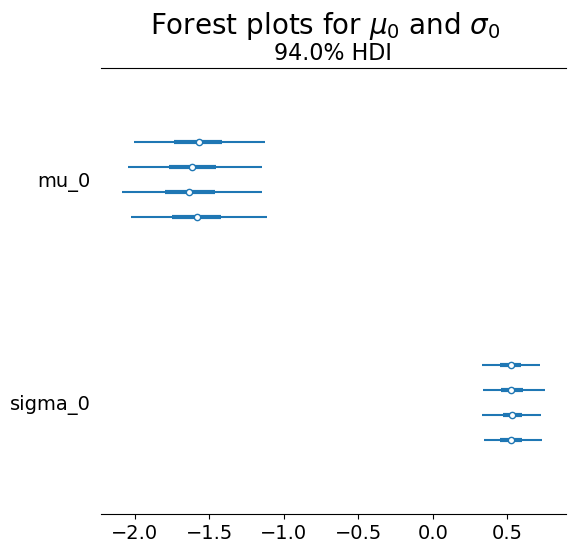

In [20]:
az.plot_forest(trace, var_names = ['mu_0', 'sigma_0']);
plt.suptitle(r'Forest plots for $\mu_0$ and $\sigma_0$', fontsize=20);

<a id="part3"></a>
    
<!-- <div class="alert alert-block alert-danger" style="color:black;background-color:#E7F4FA"> -->

## <div class='exercise'>Part 3: Varying-Coefficient Model</div> 

[Return to contents](#contents)


The next model we will fit to the contraceptives data is a **varying-coefficients logistic regression** model. Here, in addition to a varying intercept, the coefficients on `living.children`, `age_mean`, and `urban` also vary by district.

Prior distribution:

$$
\begin{split}
\beta_{0j} &\sim N(\mu_0,\sigma_0^2)\; \text{, with} \;\; \mu_0 \sim N(0,10000)\; \text{and} \; \; \frac{1}{\sigma^2_0} \sim \text{Gamma}(0.1,0.1)
\\
\beta_{1j} &\sim N(0,\sigma_1^2)\; \text{, with} \;\; \frac{1}{\sigma^2_1} \sim \text{Gamma}(0.1,0.1) 
\\
\beta_{2j} &\sim N(0,\sigma_2^2)\; \text{, with} \;\; \frac{1}{\sigma^2_2} \sim \text{Gamma}(0.1,0.1)
\\ 
\beta_{3j} &\sim N(0,\sigma_3^2)\; \text{, with} \;\; \frac{1}{\sigma^2_3} \sim \text{Gamma}(0.1,0.1)
\\
\end{split}
$$

Model for data:

$$
\begin{split}
Y_{ij} &\sim \text{Bernoulli}(p_{ij})
\\ \\
\text{logit}\:p_{ij} &= \beta_{0j} + \beta_{1j} \times \text{urban} + \beta_{2j} \times \text{living.children} + \beta_{3j} \times \text{age-mean}
\\ \\
\end{split}
$$

**PLEASE NOTE:**

* The name "varying coefficient model" is used here to distinguish the Q3 model from the "varying intercept" model in Q2, but observe from the specification about that **BOTH** intercepts *and* coefficients vary in this Q3 model.
* Once again, the $\text{Gamma}$ distribution uses the $\text{Gamma}(\alpha, \beta)$ parametrization, where $\alpha$ is the shape and $\beta$ is the rate. 

<!-- BEGIN QUESTION -->

<div class='exercise'><b>Q3.1 - Fit Varying Coefficient Model</b></div>

Fit the varying-coefficients model described above to the real training data.

In [21]:
# your code here

with pm.Model() as model:
    
    # Defining prior distributions for mu_0 and tau_0
    # N(0, 100^2)
    mu_0 = pm.Normal("mu_0", mu=0, sigma=100)
    
    # Gamma(0.1, 0.1)
    tau_0 = pm.Gamma("tau_0", alpha=0.1, beta=0.1)
    tau_1 = pm.Gamma("tau_1", alpha=0.1, beta=0.1)
    tau_2 = pm.Gamma("tau_2", alpha=0.1, beta=0.1)
    tau_3 = pm.Gamma("tau_3", alpha=0.1, beta=0.1)
    
    # Defining prior distributions for the coefficients
    B0s = pm.Normal("B0s", mu=mu_0, tau=tau_0, shape=60)
    
    Beta_1s = pm.Normal("Beta_1", mu=0, tau=tau_1, shape=60)
    Beta_2s = pm.Normal("Beta_2", mu=0, tau=tau_2, shape=60)
    Beta_3s = pm.Normal("Beta_3", mu=0, tau=tau_3, shape=60)
    
    # Defining the logistic function of the predictors
    # It calculates the logit of the probability of a positive response in each observation,
    # based on the predictor variables (urban, living.children, age_mean) and the corresponding coefficients.
    p_logit = B0s[df_train.district-1] + Beta_1s[df_train.district-1]*df_train.urban + Beta_2s[df_train.district-1]*df_train['living.children'] + Beta_3s[df_train.district-1]*df_train.age_mean
    
    # Defining the likelihood of the observed data
    # It assigns a Bernoulli distribution to the response variable, with the calculated probability of success (p_logit)
    # and the observed binary outcomes (real_train_Y)
    our_likelihood = pm.Bernoulli('our_likelihood', logit_p=p_logit, observed=real_train_Y)



<!-- BEGIN QUESTION -->

<div class='exercise'><b>Q3.2 - Convergence Diagnostics</b></div>

Check the convergence of your varying-coefficients model by examining the trace plots and R-hats, as you did with the varying-intercept models earlier. What do you observe?

**Answer to Q3.2**

For reasons outlined previously, it seems like our chains have converged once again. 

In [22]:
# We use the sample function to draw samples from the posterior distribution 
# Number of samples to draw: 2000
# `tune=2000`: number of tuning samples to discard at the beginning of the sampling process
# `target_accept=.98` for the target acceptance rate of the 
#  Metropolis-Hastings algorithm used for sampling

with model:
    
    # The trace variable will contain the samples drawn from the posterior distribution
    trace_32 = pm.sample(draws=2000, chains=4, tune=2000, target_accept=.98)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_0, tau_0, tau_1, tau_2, tau_3, B0s, Beta_1, Beta_2, Beta_3]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 129 seconds.


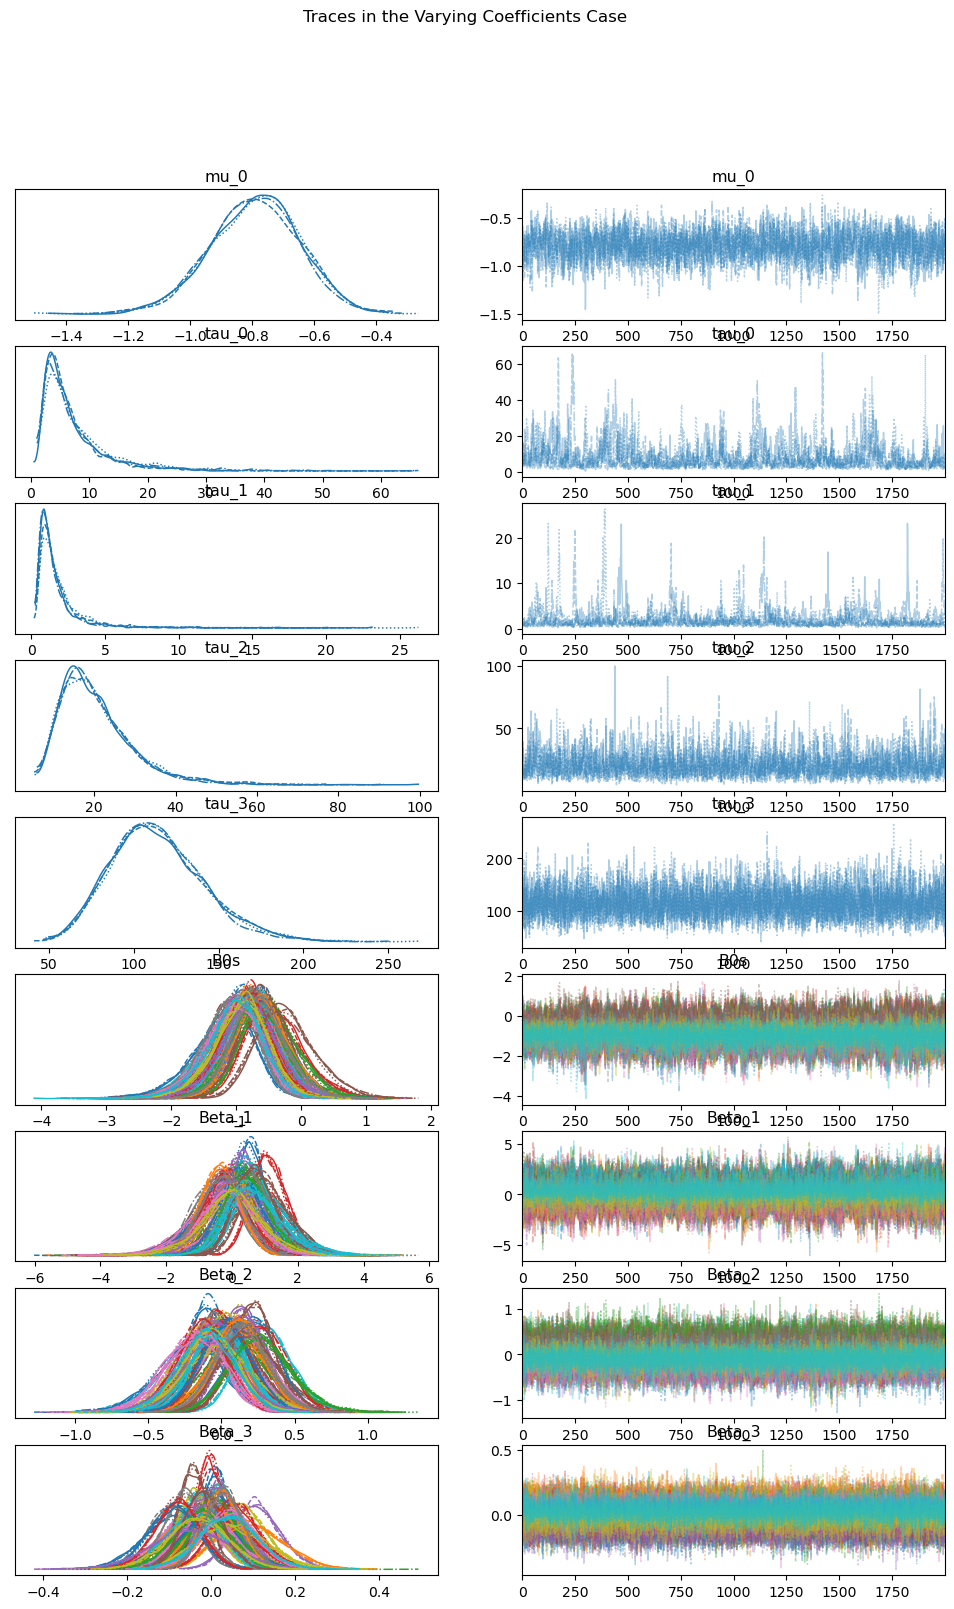

In [23]:
az.plot_trace(trace_32, var_names=['mu_0', 
                                'tau_0', 
                                'tau_1', 
                                'tau_2', 
                                'tau_3', 
                                'B0s', 
                                'Beta_1', 'Beta_2', 'Beta_3']);
plt.suptitle('Traces in the Varying Coefficients Case');

In [24]:
summary = az.summary(trace_32)

# extract the Gelman-Rubin statistic for each parameter
gelman_rubin = summary['r_hat']

# print the value counts for the Gelman-Rubin statistic
gelman_rubin.value_counts()

1.00    243
1.01      2
Name: r_hat, dtype: int64

<!-- BEGIN QUESTION -->

<div class='exercise'><b>Q3.3 - Distribution of Posterior Means & HDIs</b></div>

Plot the distributions of posterior means and the 95% highest posterior density intervals (HDIs) for the intercepts and coefficients for each district. What do you conclude from these graphs?

**HINT:** The ArviZ [`plot_forest()`](https://arviz-devs.github.io/arviz/api/generated/arviz.plot_forest.html) function is very well-suited for this task.

The posterior distributions for the coefficients overlap with 0. This suggests that there is little evidence for a relationship between the predictor and the outcome variable, at least after accounting for the other predictors in the model. However, the results for the varying intercept and varying coefficient parameters should still be interpreted based on their respective posterior distributions.

The posterior mean for $\mu_0$ is significantly different from 0, and the credible intervals for most of the districts in the forest plot for $\mu_0$ do not overlap with 0, this suggests that there is evidence for a varying intercept model.

The posterior mean for $\sigma_0$ is significantly different from 1, and the credible intervals for most of the districts in the forest plot for $\sigma_0$ do not overlap with 1, this suggests that there is evidence for a varying coefficient model.

In our case, since $\mu_0$ and $\sigma_0$ are far from 0 and 1 respectively, this suggests that there is evidence for a varying intercept and a varying coefficient model. However, the coefficients themselves do not show strong evidence for a relationship with the outcome variable. It's important to keep in mind that the interpretation of model results should always be based on the posterior distributions and credible intervals, rather than just the point estimates (such as the means).

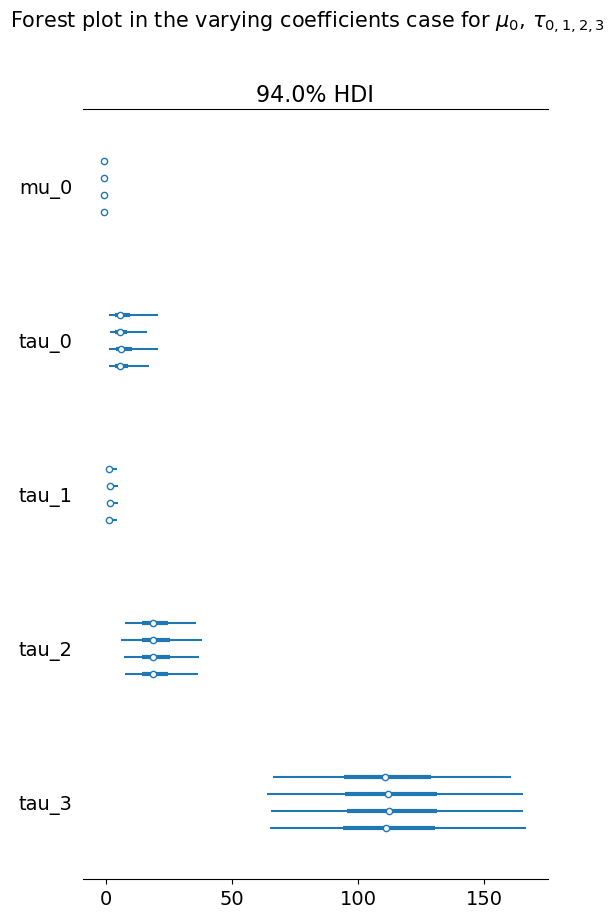

In [25]:
az.plot_forest(trace_32, var_names=['mu_0', 'tau_0', 'tau_1', 'tau_2', 'tau_3']);
plt.suptitle(r'Forest plot in the varying coefficients case for $\mu_0$, $\tau_{0,1,2,3}$', fontsize=15);

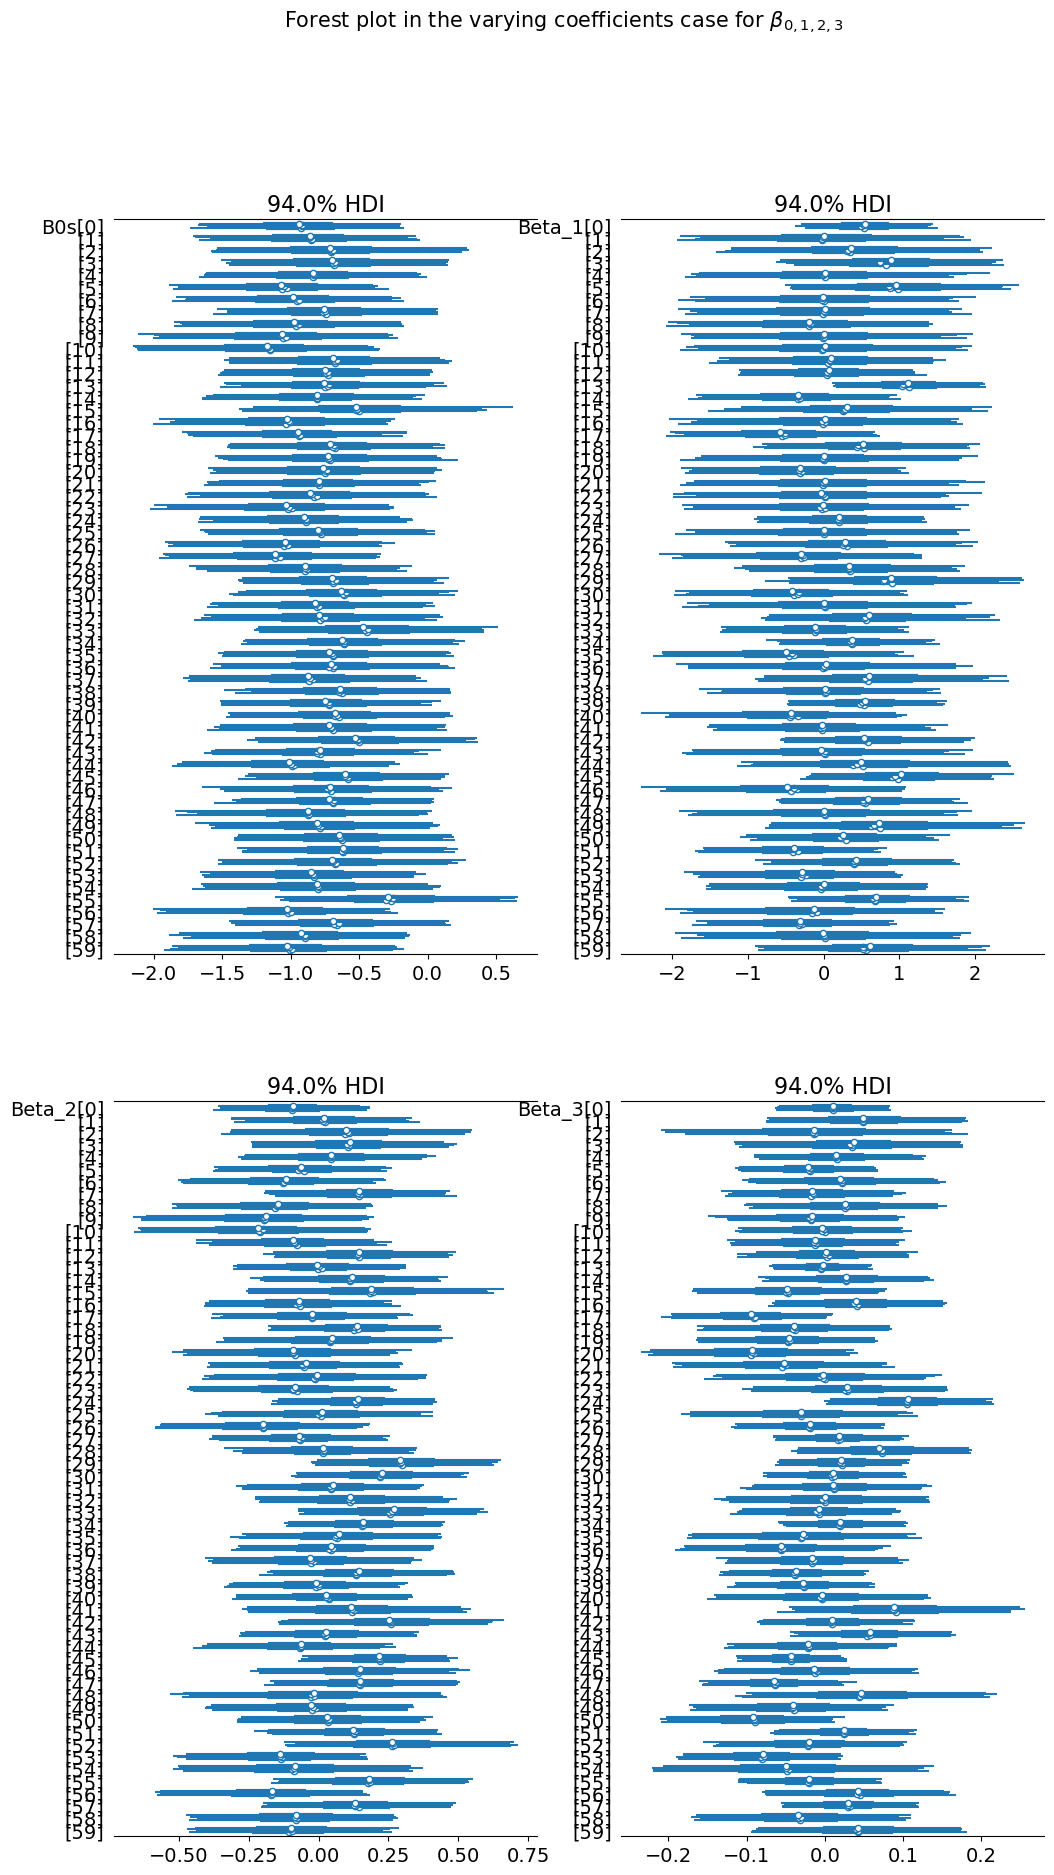

In [26]:
fig, axs = plt.subplots(2,2, figsize=(12, 21))
az.plot_forest(trace_32, var_names=["B0s"], ax=axs[0,0])
az.plot_forest(trace_32, var_names=["Beta_1"], ax=axs[0,1])
az.plot_forest(trace_32, var_names=['Beta_2'], ax=axs[1,0])
az.plot_forest(trace_32, var_names=['Beta_3'], ax=axs[1,1]);
plt.suptitle(r'Forest plot in the varying coefficients case for $\beta_{0,1,2,3}$', fontsize=15);

<a id="part4"></a>
    
<!-- <div class="alert alert-block alert-danger" style="color:black;background-color:#E7F4FA"> -->

## <div class='exercise'>Part 4: Predictions & Model Selection</div> 

[Return to contents](#contents)

<!-- BEGIN QUESTION -->

<div class='exercise'><b>Q4.1 - Create and Evaluate Classifiers</b></div>

Build two Bayesian logistic regression classifiers: one from your varying-intercept model (Q2) and another from your varying-coefficients model (Q3). Then, use each model to make predictions on your training and test sets.

* For each of the two classifiers, **on both train and test data separately**, report:
    * percentage of observations predicted to be `1` (i.e., uses contraceptives)
    * accuracy score

Finally, briefly describe the approach you used to implement these classifiers.
  
**Hint:** These classification models will make use of the samples generated by your PyMC models above, but they need not themselves be PyMC model objects. They can also be constructed out of simple Python functions of your own design.

**Approach to build Bayesian Logistic Regression Classifier using Varying-Intercept model**

(*Please note that the changes that we made to the code are also added as comments within the code itself.*)

Firstly, define prior distributions for model parameters, with the same specifications as previously:

- $\mu$: mean of the varying intercepts, which represent the effect of each district on the dependent variable.
- $\tau$: variance of the varying intercepts.
- $\beta_0$'s: set of varying intercepts for each district.
- $\beta_1, \beta_2, \beta_3$: coefficients for dependent variables

We then compute the linear predictor, which is the sum of the varying intercepts for each district and the product of each independent variable with its corresponding coefficient. The linear predictor is transformed to the logit scale, which is the logarithm of the odds of the dependent variable being 1.

Finally, we define the likelihood function using a Bernoulli distribution, which models the probability of the dependent variable being 1 as a function of the linear predictor. The observed data (i.e., actual contraceptive use status) is used to specify the values of the likelihood function.

To get the accuracy on the training data, we need to sample from the posterior distribution of the model parameters using Markov Chain Monte Carlo (MCMC) simulation. Then, we extract the samples for the model parameters from the MCMC trace. Finally, we use the samples to make predictions on the training data. This can be done by computing the probability of each observation being in the positive class (i.e., contraceptive use) using the logistic function, and then rounding the probabilities to 0 or 1.


**Approach to build Bayesian Logistic Regression Classifier using Varying-Coefficient model**

(*Please note that the changes that we made to the code are also added as comments within the code itself.*)








The model is defined using the PyMC probabilistic programming framework with `pm.Model()` as context manager. The model includes four independent variables: `urban`, `living.children`, `age_mean`, and `district`. The district variable is modeled using varying intercepts, where each district has its own intercept that is drawn from a normal distribution with a mean of `mu_0` and a variance of `tau_0`.

The coefficients for the independent variables are modeled using normal distributions with a mean of 0 and a variance of `tau_1`, `tau_2`, and `tau_3` for `urban`, `living.children`, and `age_mean`, respectively.

The likelihood function is defined using a Bernoulli distribution with a parameter of `p`, which is calculated using the linear predictor `p_logit`. The linear predictor is calculated by adding up the varying intercepts for each district and the product of each independent variable with its corresponding coefficient.

After defining the model, the posterior distribution is sampled using Markov Chain Monte Carlo (MCMC) methods, and the samples are used to make predictions on the training data. The model parameters are extracted from the samples, and the probability of contraceptive use is computed for each observation in the training data using the model equation. Finally, a binary classification is made based on whether the probability of contraceptive use is greater than or equal to $0.5$.



In [27]:
X_train = df_train.drop('contraceptive_use', axis=1)
y_train = df_train['contraceptive_use']

X_test = df_test.drop('contraceptive_use', axis=1)
y_test = df_test['contraceptive_use']

In [28]:
%%time


###### BAYESIAN LOGISTIC REGRESSION CLASSIFIER USING VARYING-INTERCEPT MODEL ########

# IN Q2.1, the likelihood had a BERNOULLI dist., which is appropriate for modelling binary data
# Instead of using a varying intercept model, we need to use a model that allows the coefficients of the 
# independent variables to vary across the different levels of the `district` variable

# Define the model
with pm.Model() as model:
    # N(0, 100^2) prior for the mean of the varying intercepts
    mu_0 = pm.Normal("mu_0", mu=0, sigma=100)

    # Gamma(0.1, 0.1) prior for the variance of the varying intercepts
    tau_0 = pm.Gamma("tau_0", alpha=0.1, beta=0.1)

    # Define the varying intercepts for each district using a Normal distribution
    # with mean mu_0 and variance tau_0
    # We specify the shape of the distribution to be the number of unique values of
    # the 'district' variable in the training data
    B0s = pm.Normal("B0s", mu=mu_0, tau=tau_0, shape=len(np.unique(df_train.district)), )

    # Define the coefficients for the independent variables
    Beta_1 = pm.Normal("Beta_1", mu=0, sigma=100)
    Beta_2 = pm.Normal("Beta_2", mu=0, sigma=100)
    Beta_3 = pm.Normal("Beta_3", mu=0, sigma=100)

    # Compute the linear predictor by adding up the varying intercepts for each district
    # and the product of each independent variable with its corresponding coefficient
    p_logit = B0s[df_train.district - 1] + Beta_1 * df_train.urban + Beta_2 * df_train['living.children'] + Beta_3 * df_train.age_mean

    # Define the likelihood function using a Bernoulli distribution with parameter
    # p = 1/(1+exp(-p_logit)) to model the binary outcome variable
    likelihood = pm.Bernoulli('likelihood', p=pm.math.invlogit(p_logit), observed=df_train.contraceptive_use)

    # Sample from the posterior distribution
    trace = pm.sample(1000, tune=1000, chains=4)

# Extract the samples for the model parameters
B0_samples = trace.posterior['B0s']
Beta_1_samples = trace.posterior['Beta_1']
Beta_2_samples = trace.posterior['Beta_2']
Beta_3_samples = trace.posterior['Beta_3']

# Make predictions on the training data
n = len(df_train)
y_pred = np.zeros(n)
for i in range(n):
    # Compute the probability of contraceptive use for this observation
    p = 0
    for j in range(len(np.unique(df_train.district))):
        B0 = B0_samples.values[:, j]
        B0 = B0.reshape(1, -1)
        p_logit = B0[:, df_train['district'][i]-1] + Beta_1_samples*df_train['urban'][i] + Beta_2_samples*df_train['living.children'][i] + Beta_3_samples*df_train['age_mean'][i]
        p += np.mean(1 / (1 + np.exp(-p_logit)))
    p /= len(np.unique(df_train.district))

    # Assign a class based on the probability of contraceptive use
    y_pred[i] = int(p >= 0.5)

# Compute the accuracy score
blr_VI_train_accuracy = np.mean(y_pred == df_train.contraceptive_use)
print('Train Accuracy:', blr_VI_train_accuracy)

percentage_blr_VI_train = np.around(np.mean(y_pred == 1) * 100,1)
print('Percentage of observations predicted to be 1:', percentage_blr_VI_train)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_0, tau_0, B0s, Beta_1, Beta_2, Beta_3]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 20 seconds.


Train Accuracy: 0.6732161323681489
Percentage of observations predicted to be 1: 16.2
CPU times: user 2min 54s, sys: 422 ms, total: 2min 55s
Wall time: 3min 11s


In [29]:
%%time

# Make predictions on the testing data
n = len(df_test)
y_pred = np.zeros(n)
for i in range(n):
    # Compute the probability of contraceptive use for this observation
    p = 0
    for j in range(len(np.unique(df_test.district))):
        B0 = B0_samples.values[:, j]
        B0 = B0.reshape(1, -1)
        p_logit = B0[:, df_test['district'][i]-1] + Beta_1_samples*df_test['urban'][i] + Beta_2_samples*df_test['living.children'][i] + Beta_3_samples*df_test['age_mean'][i]
        p += np.mean(1 / (1 + np.exp(-p_logit)))
    p /= len(np.unique(df_test.district))

    # Assign a class based on the probability of contraceptive use
    y_pred[i] = int(p >= 0.5)

# Compute the accuracy score
blr_VI_test_accuracy = np.mean(y_pred == df_test.contraceptive_use)
print('Test Accuracy:', blr_VI_test_accuracy)

percentage_blr_VI_test = np.around(np.mean(y_pred == 1) * 100,1)
print('Percentage of observations predicted to be 1:', percentage_blr_VI_test)

Test Accuracy: 0.6452947259565667
Percentage of observations predicted to be 1: 15.4
CPU times: user 2min 46s, sys: 19.9 ms, total: 2min 46s
Wall time: 2min 46s


In [30]:
%%time



###### BAYESIAN LOGISTIC REGRESSION CLASSIFIER USING VARYING-COEFFICIENT MODEL ########

# Define the model
with pm.Model() as model:
    # N(0, 100^2) prior for the mean of the varying intercepts
    mu_0 = pm.Normal("mu_0", mu=0, sigma=100)

    # Define a Gamma distribution prior with shape and rate parameters of 0.1 for the variance of the coefficients
    tau_0 = pm.Gamma("tau_0", alpha=0.1, beta=0.1)
    tau_1 = pm.Gamma("tau_1", alpha=0.1, beta=0.1)
    tau_2 = pm.Gamma("tau_2", alpha=0.1, beta=0.1)
    tau_3 = pm.Gamma("tau_3", alpha=0.1, beta=0.1)

    # Define the varying intercepts for each district using a Normal distribution
    # with mean mu_0 and variance tau_0
    # We specify the shape of the distribution to be the number of unique values of
    # the 'district' variable in the training data
    B0s = pm.Normal("B0s", mu=mu_0, tau=tau_0, shape=len(np.unique(df_train.district)), )

    # Define the coefficients for the independent variables
    B1s = pm.Normal("Beta_1", mu=0, tau=tau_1, shape=60)
    B2s = pm.Normal("Beta_2", mu=0, tau=tau_2, shape=60)
    B3s = pm.Normal("Beta_3", mu=0, tau=tau_3, shape=60)

    # Compute the linear predictor by adding up the varying intercepts for each district
    # and the product of each independent variable with its corresponding coefficient
    p_logit = B0s[df_train.district-1] + B1s[df_train.district-1]*df_train.urban + B2s[df_train.district-1]*df_train['living.children'] + B3s[df_train.district-1]*df_train.age_mean
    
    # Define the likelihood function using a Bernoulli distribution with parameter
    # p = 1/(1+exp(-p_logit)) to model the binary outcome variable
    likelihood = pm.Bernoulli('likelihood', p=pm.math.invlogit(p_logit), observed=df_train.contraceptive_use)

    # Sample from the posterior distribution
    trace = pm.sample(1000, tune=1000, chains=4)

# Extract the samples for the model parameters
B0_samples = trace.posterior['B0s']
B1_samples = trace.posterior['Beta_1']
B2_samples = trace.posterior['Beta_2']
B3_samples = trace.posterior['Beta_3']

# Make predictions on the training data
n = len(df_train)
y_pred = np.zeros(n)
for i in range(n):
    # Compute the probability of contraceptive use for this observation
    p = 0
    for j in range(len(np.unique(df_train.district))):
        B0, B1, B2, B3 = B0_samples.values[:, j], B1_samples.values[:, j], B2_samples.values[:, j], B3_samples.values[:, j]
        B0, B1, B2, B3 = B0.reshape(1, -1), B1.reshape(1, -1), B2.reshape(1, -1), B3.reshape(1, -1)
        p_logit = B0[:, df_train['district'][i]-1] + B1[:, df_train['district'][i]-1]*df_train['urban'][i] + B2[:, df_train['district'][i]-1]*df_train['living.children'][i] + B3[:, df_train['district'][i]-1]*df_train['age_mean'][i]
        p += np.mean(1 / (1 + np.exp(-p_logit)))
    p /= len(np.unique(df_train.district))

    # Assign a class based on the probability of contraceptive use
    y_pred[i] = int(p >= 0.5)

# Compute the accuracy score
blr_VC_train_accuracy = np.mean(y_pred == df_train.contraceptive_use)
print('Train Accuracy for varying coefficient model:', blr_VC_train_accuracy)

blr_VC_train_percentage = np.around(np.mean(y_pred == 1) * 100,1)
print('Percentage of observations predicted to be 1:', blr_VC_train_percentage)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_0, tau_0, tau_1, tau_2, tau_3, B0s, Beta_1, Beta_2, Beta_3]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 26 seconds.


Train Accuracy for varying coefficient model: 0.7052740434332989
Percentage of observations predicted to be 1: 25.4
CPU times: user 23 s, sys: 586 ms, total: 23.5 s
Wall time: 44.9 s


In [31]:
%%time

# Make predictions on the test data
n = len(df_test)
y_pred = np.zeros(n)
for i in range(n):
    # Compute the probability of contraceptive use for this observation
    p = 0
    for j in range(len(np.unique(df_test.district))):
        B0, B1, B2, B3 = B0_samples.values[:, j], B1_samples.values[:, j], B2_samples.values[:, j], B3_samples.values[:, j]
        B0, B1, B2, B3 = B0.reshape(1, -1), B1.reshape(1, -1), B2.reshape(1, -1), B3.reshape(1, -1)
        p_logit = B0[:, df_test['district'][i]-1] + B1[:, df_test['district'][i]-1]*df_test['urban'][i] + B2[:, df_test['district'][i]-1]*df_test['living.children'][i] + B3[:, df_test['district'][i]-1]*df_test['age_mean'][i]
        p += np.mean(1 / (1 + np.exp(-p_logit)))
    p /= len(np.unique(df_test.district))

    # Assign a class based on the probability of contraceptive use
    y_pred[i] = int(p >= 0.5)

# Compute the accuracy score
blr_VC_test_accuracy = np.mean(y_pred == df_test.contraceptive_use)
print('Test Accuracy for varying coefficient model:', blr_VC_test_accuracy)

blr_VC_test_percentage = np.around(np.mean(y_pred == 1) * 100,1)
print('Percentage of observations predicted to be 1:', blr_VC_test_percentage)

Test Accuracy for varying coefficient model: 0.6184074457083765
Percentage of observations predicted to be 1: 24.9
CPU times: user 5.23 s, sys: 888 µs, total: 5.23 s
Wall time: 5.22 s


<!-- BEGIN QUESTION -->

<div class='exercise'><b>Q4.2 - Comparison to Naive Model</b></div>

Report the same four metrics from the previous question for a 3rd, "naive" model that always predicts the most frequent outcome observed in the training data.

In [32]:
%%time 

# your code here

def naive_model(X):
    """
    Train a "naive" model to predict the target variable in a pandas DataFrame.

    This function takes in a pandas DataFrame (X) that contains a target variable
    called "contraceptive_use". It then creates a "naive" prediction array by
    determining the mode of the target variable and assigning that value to all
    elements in the prediction array. It then calculates the accuracy of this
    "naive" model by comparing the prediction array to the true values in the
    DataFrame X.

    Parameters:
    -----------
    X : pandas.DataFrame
        A DataFrame that contains the target variable "contraceptive_use".

    Returns:
    --------
    tuple of (str, float)
        A tuple containing a string describing the output value, which is the
        accuracy of the "naive" model as a float between 0 and 1.
    """
    
    # Determine the mode of the target variable
    mode_value = X['contraceptive_use'].mode()[0]
    # The mode function from pandas returns the most common value(s) in a DataFrame
    # column. The [0] at the end of the line is used to select the first value in
    # the resulting series (which will be the mode if there is only one).

    # Create a prediction array with the same length as the test data
    prediction_array = np.full_like(X['contraceptive_use'], mode_value)
    # The full_like function from NumPy creates a new array with the same shape and
    # type as the input array (in this case, the "contraceptive_use" column of X).
    # The second argument is the value that will be assigned to all elements in the
    # new array.

    # Calculate the accuracy of the "naive" model
    accuracy = np.mean(prediction_array == X['contraceptive_use'])
    # The mean function from NumPy calculates the average of a boolean array (where
    # True = 1 and False = 0). In this case, we are comparing the "prediction_array"
    # to the "contraceptive_use" column of X using the == operator, which returns a
    # boolean array indicating which elements are equal.
    
    percentage = np.around(np.mean(prediction_array == 1) * 100, 1)

    return accuracy, percentage
    # The function returns a tuple containing a string (which is the description of
    # the value that follows it) and the value of the "accuracy" variable.


blr_naive_train_accuracy = naive_model(df_train)[0]
blr_naive_test_accuracy = naive_model(df_test)[0]
percentage_BLR_naive_train = naive_model(df_train)[1]
percentage_BLR_naive_test = naive_model(df_test)[1]

CPU times: user 3.6 ms, sys: 6 µs, total: 3.6 ms
Wall time: 2.87 ms


<!-- BEGIN QUESTION -->

<div class='exercise'><b>Q4.3 - Model Selection</b></div>

What do you conclude from the results of 4.1 & 4.2? Which model appears to be the best (i.e. varying-intercept, varying-coefficient, or naive), and what is your rationale?

In [33]:

data = {'Model': ['BLR: Varying Intercept', 'BLR: Varying Coefficient', 'BLR: Naive'],
        'Train accuracy': [blr_VI_train_accuracy, 
                           blr_VC_train_accuracy, blr_naive_train_accuracy],
        'Test accuracy': [blr_VI_test_accuracy, 
                           blr_VC_test_accuracy, blr_naive_test_accuracy], 
       'Predicted contraceptive use -- Training data (%)':[percentage_blr_VI_train, 
                                      blr_VC_train_percentage, percentage_BLR_naive_train], 
       'Predicted contraceptive use -- Test data (%)':[percentage_blr_VI_test, 
                                      blr_VC_test_percentage, percentage_BLR_naive_test]}

# Create the data frame
metrics_df = pd.DataFrame(data)
metrics_df

,Model,Train accuracy,Test accuracy,Predicted contraceptive use -- Training data (%),Predicted contraceptive use -- Test data (%)
0,BLR: Varying Intercept,0.673216,0.645295,16.2,15.4
1,BLR: Varying Coefficient,0.705274,0.618407,25.4,24.9
2,BLR: Naive,0.610134,0.604964,0.0,0.0


The model with the highest test accuracy is the first model with only varying intercepts. This model has roughly the same train and test accuracy, which suggests that it is not overfitting to the training data and has a good generalization ability to new data.

The second model with both varying intercepts and coefficients has a higher training accuracy compared to the first model, but a lower test accuracy. This indicates that the model might be overfitting to the training data and not able to generalize well to new data.

One possible reason for the higher test accuracy of the model with only varying intercepts compared to the model with both varying intercepts and coefficients is overfitting. The model with both varying intercepts and coefficients has more parameters than the model with only varying intercepts, which means it has more flexibility to fit the training data. This can lead to overfitting, where the model fits the noise in the training data instead of the underlying pattern. As a result, the model may perform well on the training data but poorly on the test data. On the other hand, the model with only varying intercepts may be more robust to overfitting because it has fewer parameters. By constraining the model in this way, it may be more likely to capture the underlying pattern in the data and generalize well to new data.

The third model, which is the naive model that always predicts the most frequent outcome, has a lower accuracy than both Bayesian logistic regression models. This is expected because it does not take into account the relationships between the independent variables and the outcome variable and simply predicts the most frequent outcome, which may not always be the correct prediction.

Therefore, based on the last table, it is recommended to choose the first model with only varying intercepts. However, it is important to note that other factors such as the specific problem context, the cost of misclassification, and the interpretability of the model should also be taken into consideration when selecting the final model.

<!-- BEGIN QUESTION -->

<div class='exercise'><b>Q4.4 Wrap-up</b></div>

* In a few sentences, please describe the aspect(s) of the assignment you found most challenging. This could be conceptual and/or related to coding and implementation.

* How many hours did you spend working on this assignment? Store this as an int or float in `time_spent_on_hw`

BY FAR the fact that there is so little documentation on PyMC!!

In [34]:
time_spent_on_hw = 20

In [35]:
grader.check("q4.4")

q4.4 results: All test cases passed!

In [36]:
time_end = time.time()
print(f"It took {(time_end - time_start)/60:.2f} minutes for this notebook to run")

It took 12.84 minutes for this notebook to run


**This concludes HW2. Thank you!**